In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

if "workding_dir" not in locals():
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        workding_dir = "/content/drive/MyDrive/logical-reasoning/"
    except ModuleNotFoundError:
        workding_dir = str(Path.cwd().parent)

In [3]:
import os
import sys

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/projects/logical-reasoning


In [4]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/projects/logical-reasoning/.env


True

In [5]:
import os

model_name = os.getenv("MODEL_NAME")
data_path = os.getenv("LOGICAL_REASONING_DATA_PATH")
results_path = os.getenv("LOGICAL_REASONING_RESULTS_PATH")
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(model_name, data_path, results_path, max_new_tokens)

internlm/internlm2_5-7b-chat-1m datasets/mgtv data/openai_results.csv 2048


In [6]:
from llm_toolkit.logical_reasoning_utils import *

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py


In [7]:
model_name = "anthropic"
result_csv = f"data/{model_name}_results.csv"
metrics_csv = f"data/{model_name}_metrics.csv"

In [8]:
import pandas as pd

df = pd.read_csv(result_csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   text                                 3000 non-null   object
 1   label                                3000 non-null   object
 2   title                                3000 non-null   object
 3   puzzle                               3000 non-null   object
 4   truth                                3000 non-null   object
 5   claude-3-5-sonnet-20240620/shots-00  3000 non-null   object
dtypes: object(6)
memory usage: 140.8+ KB


In [9]:
df.columns.to_list()

['text',
 'label',
 'title',
 'puzzle',
 'truth',
 'claude-3-5-sonnet-20240620/shots-00']

In [10]:
result_columns = df.columns.to_list()[5:]
result_columns.sort()
result_columns

['claude-3-5-sonnet-20240620/shots-00']

In [11]:
# sort columns
df2 = df[
    [
        "text",
        "label",
        "title",
        "puzzle",
        "truth",
    ]
].copy()
df2[result_columns] = df[result_columns]

In [12]:
df = df2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   text                                 3000 non-null   object
 1   label                                3000 non-null   object
 2   title                                3000 non-null   object
 3   puzzle                               3000 non-null   object
 4   truth                                3000 non-null   object
 5   claude-3-5-sonnet-20240620/shots-00  3000 non-null   object
dtypes: object(6)
memory usage: 140.8+ KB


In [13]:
df["label"].value_counts()

label
不是      1535
是       1245
不重要      138
问法错误      47
回答正确      35
Name: count, dtype: int64

In [14]:
perf_df = get_metrics_df(df, variant="shots")
perf_df

/Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py:438: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_df = pd.concat(


shots                       model                                  run  \
0     0  claude-3-5-sonnet-20240620  claude-3-5-sonnet-20240620/shots-00   

   accuracy  precision  recall        f1  ratio_valid_classifications  
0     0.698   0.793375   0.698  0.730474                          1.0

In [15]:
perf_df.to_csv(metrics_csv, index=False)

0: claude-3-5-sonnet-20240620/shots-00


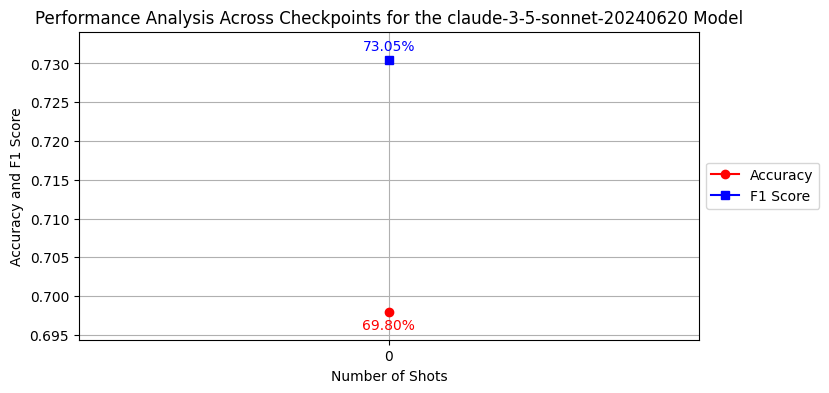

In [16]:
plot_metrics(perf_df, "claude-3-5-sonnet-20240620", variant="shots", offset=0.002)

********** claude-3-5-sonnet-20240620/shots-00 **********
claude-3-5-sonnet-20240620/shots-00
不是      1460
是        898
不重要      294
问法错误     203
回答正确     145
Name: count, dtype: int64


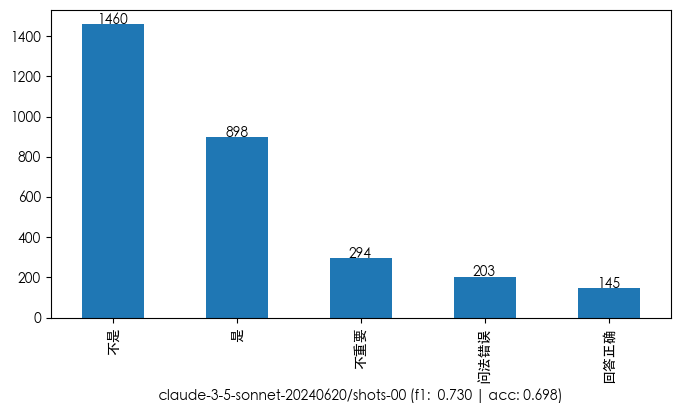

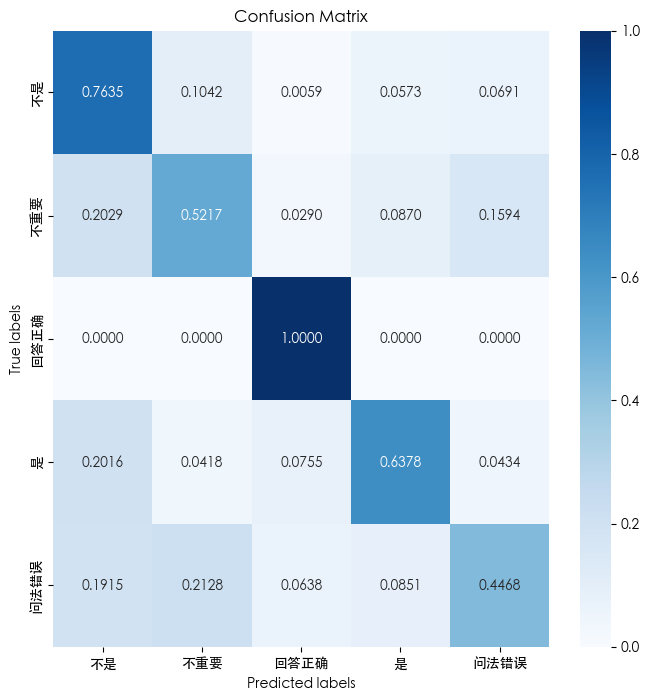

In [18]:
for col, f1, accuracy in zip(
    df.columns[5:], perf_df["f1"].to_list(), perf_df["accuracy"].to_list()
):
    print("*" * 10, col, "*" * 10)
    print(df[col].value_counts())
    plot_value_counts(df, col, title=f"{col} (f1: {f1: .3f} | acc: {accuracy:.3f})", preprocess_func=extract_answer)